# Finding discords of any length in a time series

This tutorial explains the MERLIN algorithm, proposed in [MERLIN](https://www.cs.ucr.edu/~eamonn/MERLIN_Long_version_for_website.pdf). The support webpage can be found here: [MERLIN: SUPPORT](https://sites.google.com/view/merlin-find-anomalies).

The algorithm discovers the discords of arbitrary length in time series. It is worthwhile to note that the term arbitrary means the user can define a range for the length of discord (i.e. minimum length, `minL`, and maximum length, `maxL`). The algorithm finds discords of different lengths `L` $\in$ `[minL, maxL]`.

## What is a discord?
A subsequence of length `L` in a time series `T` is a discord **iff** it has the largest distance (hereafter being referred to as `discord_dist`) to its `[first]` nearest neighbor (`NN`). The neighbors of a subsequence of length `L`, starting at index `i`, is any other subsequences that start at an index `j`, such that `j!=i`. However, if `i` and `j` are very close to each other, the comparison between their corresponding subsequences is considered to be trivial. To this end, an exclusion zone (hereafter being referred to as `excl_zone`) is taken into account to ignore the neighbors (i.e. subsequences) whose starting index is in numpy indexing `[i-excl_zone : i+excl_zone+1]`. 

**NOTE:** <br>
It is important to note that for the subsequenc `S = T[i:i+L]`, some of its neighbors are located on the left of `S` (i.e. the ones with starting index less than/equal to `max(0, i-excl_zone-1)`) and some of its neighbors are located on the right of `S` (i.e. the ones with starting index greater than/equal to `min(len(T), i+excl_zone+1)`). To find the `NN` of a subsequence `S`, the distance between `S` and all of its `[left and right]` neighbors must be obtained.

## MatrixProfile approach

How can we discover a discord of length `L` using MatrixProfile(`P`)? The solution is straightforward. `P` shows the distance of each subsequence to its `NN`. Therefore, the one that has the greatest distance to its `NN` is considered as the discord.

There are some advantages/disadvantages in using `P` when it comes to discovering discords:

* **Advantage:** <br>
Once we have the `P`, finding the discord is easy. Also, one can obtain the `top-k` discords very quickly by locating the first `k` largest distances in `P`.

* **Disadvantage:** <br>
`P` needs to be calculated for each new length `L` in `[minL, maxL]`, and, consequently, ALL pair-wise distances need to be calculated. Because, ALL pairwise distances are required for obtaining `P`. 

As will be shown later, `MERLIN` can skip some  of the pair-wise distance calculations. Also, it can use the `discord_dist` of length `L` to narrow down the search space for disovering the discord of length `L+1`.

## MERLIN

There are two main ideas at the core of the `MERLIN` algorithm. In below, we briefly explain each concept. Then, we will show its implementation and discuss its performance.

### Idea (1): Elimination Approach
The idea can be explained as follows: Suppose we are told that the discord distance (`discord_dist`) of length `L` is at least `min_dist` (Please note that the "how" of setting the `min_dist` value will be explained later in Idea(2)). That means the distance between the discord and each one of its neighbors is at least min_dist. We start scanning the subsequences. If, for a subsequence S, we realize that it has a neighbor to which its distance is smaller than `min_dist`, we can say S cannot be the discord. 

The main idea is to eliminate all subsequences for which there exist at least one neighbor with pair-wise distance less than `min_dist`. Therefore, the remaining subsequences (i.e. candidates) are the ones that have a distance great than/equal to `min_dist`. Now, we can find the `NN` of each candidate and choose the discord, i.e. the one that has the greatest distance to its `NN`. 

---

The smaller amount of candidates is the better. This is where choosing a good value for `min_dist` becomes important. For instance, let us consider two very extreme scenarios:

**Scenario I:** Choosing a VERY SMALL value `min_dist = 1e-100`. In this case, we are most likly ended up with almost all subsequnces as the candidates.

**Scenario II:** Choosing a VERY LARGE value `min_dist = 1e+100`. In this case, we are most likely ended up with no candidates at all. 

In below, we explain how MERLIN chooses the value for `min_dist`.

### Idea (2): Choosing `min_dist`
Let us assume we already discovered the discord `d` of length `L` whose distance to its NN (`d_NN`) is `discord_dist`. Now, to find the discord of length `L+1`, we can set `min_dist = discord_dist`. Because we are increasing the length of subsequences by one, we can say their distance to their neighbors are larger compared to the case where the length was L. So, `min_dist`can be considered as a safe choice for discovering discord of length `L+1`.

However, we need a way to set the value of `min_dist` for the discord of length `L = minL`. We cannot use the `discord_dist` as we haven't discovered any discord yet! In this case, we set `min_dist` to the maximum possible distance between two z-normalized subsequences. Using a simple calculation, it can be shown that such distance is `2*sqrt(L)`. Then, if we find no candidates (similar to the Scenario II above), we can reduce the `min_dist`. 

## Implement MERLIN
It is worthwhile to note that a faster version of MERLIN is provided on the MERLIN's support webpage [MERLIN: SUPPORT](https://sites.google.com/view/merlin-find-anomalies). However, for now, we implement the veersion proposed in the original paper as it can be implemented in a cleaner/more understandable way.

### Import libraries

In [1]:
%matplotlib inline

import pandas as pd
import stumpy
from stumpy import core, config
import numpy as np
import matplotlib.pyplot as plt
import math
import time

plt.style.use('stumpy.mplstyle')

### Import (toy) data
data set is available at: 
https://drive.google.com/file/d/1cDkZVKYse_E0_fGZqTRQZrrMBRFrR2Mv/view


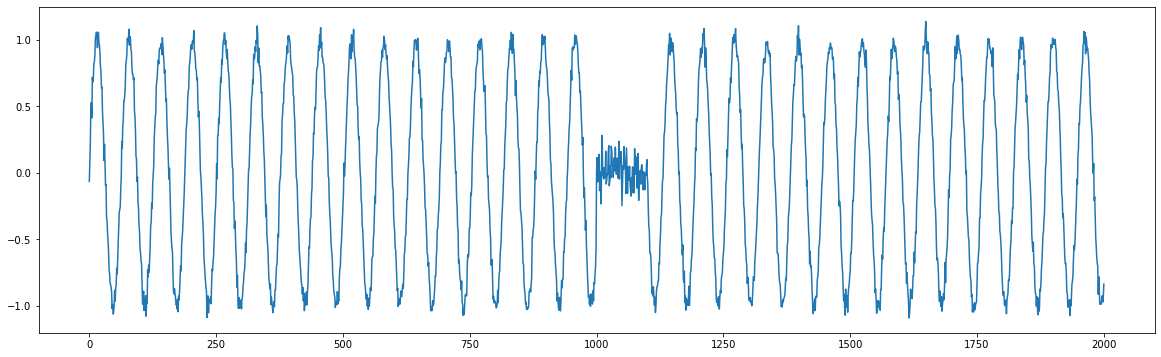

In [2]:
from scipy.io import loadmat

data = loadmat("MERLIN_datasets\\NoisySine.mat") 
ts = data['T'].reshape(-1,)

#visualize data
plt.plot(ts)
plt.show()

As we can see there is an anomaly located in about the middle of the time series data. Next, we will implement and then use MERLIN to discover the discord.

### MERLIN- Part (I): DRAG --> Selecting Candidates \[for discord of length L\]
As explained before, the idea is to select a number of candidates by eliminating undesirable subsequences. A candidate is a subsequence whose distance to all of its neighbors are at least `min_dist` (then, we can search among these candidates and find the discord) Since some neighbors of a subsequence is located on its left and others on its right, this part can be done in two phases as follows 

**MERLIN-Part(I): DRAG - Phase (I) --> Select Candidates** <br>
It is important to note that the term "candidates" in "select candidates" is different than the one we discussed so far. Here, some of the candidates (as will be explained shortly) might be false positive! That means, they HAVE a neighbor to which their distance is smaller than `min_dist`. These false positives will be pruned in the second phase of DRAG. 

In this phase, we compare each subsequence (i.e. potential candidate) with ALL of its RIGHT neighbors by calculating their dot product (instead of their euclidean distance). **NOTE:** We might end up with some false positives because we haven't check the LEFT neighbors YET. We compare each candidate with its LEFT neighbors in the second phase (to prune the false positives).

In [9]:
def select_candidates(subsequences, min_dist):
    """
    For a time series T, this function finds a set of candidates whose distance to all of their RIGHT neighbors is 
    at least min_dist. 
    
    Parameters
    ---------
    subsequences: ndarray 
    subsequences[i,:] contains a z-normalized subsequence of the main time series that starts at index "i".
    
    min_dist: scalar 
    the lowest z-normalized Euclidean distance that a discord should have with ALL of its neighbors. 
    
    NOTE: min_dist is passed to this function when it is called inside the main function MERLIN.
    
    
    output
    --------
    cand_index: ndarray
    contains the starting index of candidates.
    """
    
    n, m = subsequences.shape #n: total number of subsequences; m: length of each subsequence
    excl_zone = int(np.ceil(m / config.STUMPY_EXCL_ZONE_DENOM)) 
    
    #####################################################
    # convert min_dist to its corresponding value that can be obtained by...
    #...the dot product of two z-normalized subsequences
    r = m * (1 - ((min_dist ** 2)  / (2 * m))) 
    
    #NOTE: while min_dist is the LOWER BOUND (for a candidate and all of its neighbor), r is the UPPER BOUND...
    #...for their dot product!!! In other words, if their dot product becomes greater than r, that means they...
    #...cannot be considered as the candidates.
    
    #####################################################
    
    cand_index = np.empty(shape=(0, ), dtype=np.int64) 
    for i in range(n):
        T_i = subsequences[i,:] 
        
        cand_index_eligible = cand_index[cand_index <= (i - excl_zone-1)]   #the candidates whose RIGHT neighbor is T_i.
        corr = np.matmul(subsequences[cand_index_eligible], T_i.T)
        
        idx_reject = np.where(corr > r)[0] 
        if len(idx_reject) == 0: 
            cand_index = np.append(cand_index, i) #Add the subsequence T_i itself to the candidates 
        
        else:
            #i.e. the distance between some candidates and their RIGHT neighbor T_i is below min_dist. So, remove them!
            cand_index = np.delete(cand_index, idx_reject)  
            
            #NOTE: Also, no need to add the T_i itself to the candidates. Because, ... 
            #... it has a (left) neighbor to which their distance is less than min_dist!
            
            
    return cand_index
    

In [10]:
#input (as provided by the  authors of paper)
m = 512 
min_dist = 10.27 #min_dist is not required for MERLIN. This is just to show the code works.

subsequences = core.z_norm(core.rolling_window(ts, m), axis=1)

In [11]:
cand_index = select_candidates(subsequences, min_dist)
cand_index

array([ 584,  585,  586,  587,  588,  589,  590,  591,  592,  593,  594,
        595,  596,  597,  598,  599,  600,  601,  602,  603,  604,  613,
        614,  615,  616,  617,  618,  619,  620,  621,  622,  623,  624,
        625,  626,  627,  628,  629,  630,  631,  632,  633,  634,  646,
        647,  648,  649,  650,  651,  652,  653,  654,  655,  656,  657,
        658,  659,  660,  661,  662,  663,  664,  665,  677,  678,  679,
        680,  681,  682,  683,  684,  685,  686,  687,  688,  689,  690,
        691,  692,  693,  694,  695,  696,  710,  711,  712,  713,  714,
        715,  716,  717,  718,  719,  720,  749,  750,  751,  780,  781,
        906,  907,  908, 1362, 1363, 1364, 1367, 1368, 1369, 1370, 1371,
       1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1393,
       1394, 1395, 1396, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407,
       1408, 1409, 1410, 1414, 1415, 1416, 1417, 1418, 1419, 1421, 1422,
       1423, 1424, 1425, 1426, 1427, 1428, 1429, 14

The number of so-far-selected candidates (186) are about one-tenth of total number of subsequences (1490). Also, some of them might be False Positives (that will be handled in the second phase.). 

Let's see if the anomaly part of the time series is covered by the selected candidates:

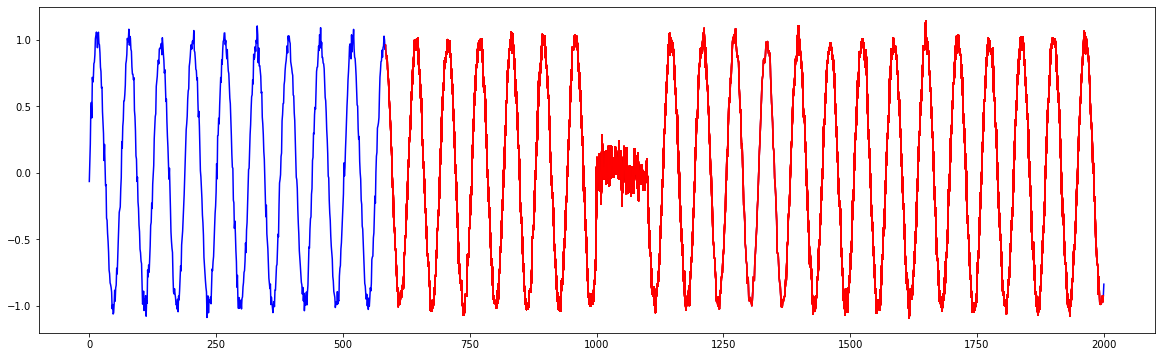

In [12]:
plt.plot(ts, c='b')
for idx in cand_index:
    plt.plot(np.arange(idx,idx+m), ts[idx:idx+m], c='r')
plt.show()

As illustrated, the selected candidates cover the anomaly. Next, we implement the second phase of DRAG, Prune Candidates, which is basically just comparing the selected candidates will their LEFT neighbors.